# Внедрение улучшенной рекомендательной системы (Выпускной проект: A/B-тестирование)

**Цель исследования:**

* Провести оценку результатов A/B-теста.

**Постановка задачи**
Оценим корректность проведения теста:

- удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
- проверим равномерность распределения пользователей по тестовым группам и правильность их формирования.


**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**Исследование будет проходить в несколько этапов:**
1. Откроем файлы с данными и изучим общую информацию.
2. Предобработка данных:
    - Требуется ли преобразование типов?
    - Опишем природу пропущенных значений и дубликатов, если их обнаружим.
3. Оценим корректность проведения теста, а именно:
    - Соответствие данных требованиям технического задания. Проверим корректность всех пунктов технического задания.
    - Время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями.
    - Аудиторию теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.
4. Исследовательский анализ данных:
    - Количество событий на пользователя одинаково распределены в выборках?
    - Как число событий в выборках распределено по дням?
    - Как меняется конверсия в воронке в выборках на разных этапах?
    - Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
5. Оценим результаты A/B-тестирования:
    - Что можно сказать про результаты A/В-тестирования?
    - Проверим статистическую разницу долей z-критерием.
6. Общий вывод.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
pd.set_option('display.max_colwidth', 0)
from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2

## Откроем файлы с данными и изучим общую информацию

In [2]:
final_ab_events = pd.read_csv('C:\\StudentYandex\\Projekts\\Python\\ProjektXvupusk\\ABtest\\final_ab_events.csv');
ab_project_marketing_events = pd.read_csv('C:\\StudentYandex\\Projekts\\Python\\ProjektXvupusk\\ABtest\\ab_project_marketing_events.csv');
final_ab_new_users = pd.read_csv('C:\\StudentYandex\\Projekts\\Python\\ProjektXvupusk\\ABtest\\final_ab_new_users.csv');
final_ab_participants = pd.read_csv('C:\\StudentYandex\\Projekts\\Python\\ProjektXvupusk\\ABtest\\final_ab_participants.csv')

In [3]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [4]:
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [5]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


**Вывод:**


Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Предобработка данных

**Проверим типы данных, дубликаты и пропуски:**

In [7]:
display(final_ab_events.info()) # Получаем информацию о таблице
display(final_ab_events.duplicated().sum()) # Проверяем количество дубликатов
final_ab_events.isna().sum() # Проверяем количество пропусков в каждом столбце

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

0

user_id       0     
event_dt      0     
event_name    0     
details       377577
dtype: int64

In [8]:
final_ab_events.groupby('event_name').agg({'details':'count'})

,details
event_name,
login,0
product_cart,0
product_page,0
purchase,62740


In [9]:
final_ab_events['details'] = final_ab_events['details'].fillna(0)

* Явные дубликаты в таблице `final_ab_events` - отсутствуют. Обнаружили пропуски в столбце `details`. Заполнен только для покупок, `purchase`, хранится стоимость покупки в долларах; `product_cart` - по всей видимости отображает когда пользователь зашел на страницу "корзина с товарами"; `product_page` - отображает когда пользователь зашел на "страницу продукта"; `login` - событие когда пользователь "авторизовался". Заполнили эти пропуски числом `0`, для удобной работы с таблицей в дальнейшем.

In [10]:
final_ab_events['event_dt'] = final_ab_events['event_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [11]:
final_ab_events['event_date'] = final_ab_events['event_dt'].map(lambda x: dt.datetime.date(x))

* Тип данных столбца `event_dt` таблицы `final_ab_events` - `object`, привели к типу `datetime` и добавили еще 1 столбец `event_date` - где отобразили только дату события;

In [12]:
display(ab_project_marketing_events.info()) # Получаем информацию о таблице
display(ab_project_marketing_events.duplicated().sum()) # Проверяем количество дубликатов
ab_project_marketing_events.isna().sum() # Проверяем количество пропусков в каждом столбце

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

0

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [13]:
ab_project_marketing_events['start_dt'] = ab_project_marketing_events['start_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
ab_project_marketing_events['finish_dt'] = ab_project_marketing_events['finish_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


* В таблице `ab_project_marketing_events` пропуски и явные дубликаты отсутствуют;
* Тип данных столбцов `start_dt` и `finish_dt` таблицы `ab_project_marketing_events` - `object`, привели к типу `datetime`;

In [14]:
display(final_ab_new_users.info()) # Получаем информацию о таблице
display(final_ab_new_users.duplicated().sum()) # Проверяем количество дубликатов
final_ab_new_users.isna().sum() # Проверяем количество пропусков в каждом столбце

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

0

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [15]:
final_ab_new_users['first_date'] = final_ab_new_users['first_date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

* В таблице `final_ab_new_users` пропуски и явные дубликаты отсутствуют;
* Тип данных столбца `first_date` таблицы `final_ab_new_users` - `object`, привели к типу `datetime`;

In [16]:
display(final_ab_participants.info()) # Получаем информацию о таблице
display(final_ab_participants.duplicated().sum()) # Проверяем количество дубликатов
final_ab_participants.isna().sum() # Проверяем количество пропусков в каждом столбце

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

0

user_id    0
group      0
ab_test    0
dtype: int64

* в таблице `ab_project_marketing_events` пропуски и явные дубликаты отсутствуют, типы данных так же в порядке - оставляем без изменений;

**Вывод:**

* Явные дубликаты в таблице `final_ab_events` - отсутствуют. Обнаружили пропуски в столбце `details`. Заполнен только для покупок, `purchase`, хранится стоимость покупки в долларах; `product_cart` - по всей видимости отображает когда пользователь зашел на страницу "корзина с товарами"; `product_page` - отображает когда пользователь зашел на "страницу продукта"; `login` - событие когда пользователь "авторизовался". Заполнили эти пропуски числом `0`, для удобной работы с таблицей в дальнейшем.
* Тип данных столбца `event_dt` таблицы `final_ab_events` - `object`, привели к типу `datetime` и добавили еще 1 столбец `event_date` - где отобразили только дату события;
* В таблице `ab_project_marketing_events` пропуски и явные дубликаты отсутствуют;
* Тип данных столбцов `start_dt` и `finish_dt` таблицы `ab_project_marketing_events` - `object`, привели к типу `datetime`;
* В таблице `final_ab_new_users` пропуски и явные дубликаты отсутствуют;
* Тип данных столбца `first_date` таблицы `final_ab_new_users` - `object`, привели к типу `datetime`;
* в таблице `ab_project_marketing_events` пропуски и явные дубликаты отсутствуют, типы данных так же в порядке - оставляем без изменений;

## Оценим корректность проведения теста

Еще раз посмотрим на наше ТЗ:

**1. Название теста: recommender_system_test**

In [17]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [18]:
display(final_ab_participants['ab_test'].unique())
final_ab_participants.groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test > 1').count()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

ab_test    1602
dtype: int64

* В таблицу участников теста `final_ab_participants` зачесались данные другого теста, а именно `interface_eu_test` - конкурирующий тест. 
* Есть пересечения в группах нашего теста и конкурирующего. Всего 1602 пользователя учавствуют сразу в двух тестах.
* Нам интересны только те пользователи которые попали в группу `A`(контрольную) теста `interface_eu_test`, иначе будет непонятно, что именно повлияло на действия пользователя новая система рекомендаций или новый интерфейс.

In [19]:
# создаем таблицу recommender_system_test с пользователями данного теста
recommender_system_test = final_ab_participants.loc[final_ab_participants['ab_test']=='recommender_system_test'][['user_id','group']]
# создаем таблицу interface_eu_test с пользователями данного теста и группой А
interface_eu_test = final_ab_participants.loc[(final_ab_participants['ab_test']=='interface_eu_test')\
& (final_ab_participants['group']=='A')][['user_id','group']].rename(columns={'group':'group_a'})
# обьединяем таблицы чтобы получить список пересечения
users_one_group = recommender_system_test.merge(interface_eu_test)[['user_id','group_a']]
# получаем список пользователей которые не пересекаются между тестами
users_two_group = final_ab_participants\
.groupby(['user_id']).agg({'ab_test':'nunique'}).reset_index().query('ab_test == 1')
# Объединяем таблицы и получаем конечный список с нашим тестом без "лишних" user_id
final_ab_participants_filtered = final_ab_participants.merge(users_two_group.merge(recommender_system_test)\
.merge(users_one_group, how='outer')[['user_id','group_a']])[['user_id','group','ab_test']].query('ab_test=="recommender_system_test"')
final_ab_participants_filtered.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
4,04988C5DF189632E,A,recommender_system_test
6,482F14783456D21B,B,recommender_system_test


* Создали новую таблицу `final_ab_participants_filtered`, в нее включили отфильтрованные данные;

**2. Группы: А — контрольная, B — новая платёжная воронка**

In [20]:
final_ab_participants_filtered['group'].unique()

array(['A', 'B'], dtype=object)

* В столбце `group`таблицы `final_ab_participants` 2 значения `A` и `B` - лишних и пропущенных значений нет;

In [21]:
final_ab_participants_filtered.groupby('user_id').agg({'group':'nunique'}).query('group > 1')

,group
user_id,


* В нашей таблице нет участников теста котороый попали сразу в 2 группы(контрольную и экспериментальную) - это очень радует;

**3. Дата запуска теста: 2020-12-07**

In [22]:
min_reg_date = final_ab_participants_filtered.merge(final_ab_new_users)['first_date'].min()
min_reg_date

Timestamp('2020-12-07 00:00:00')

* в данных информация о пользователях зарегистрировавшихся 07.12.2020 и позже;

**4. Дата остановки набора новых пользователей: 2020-12-21**

In [23]:
max_reg_date = final_ab_participants_filtered.merge(final_ab_new_users)['first_date'].max()
max_reg_date

Timestamp('2020-12-21 00:00:00')

* В данных информация о пользователях зарегистрировавшихся до 21.12.2020;

**Убедимся, что во время проведения теста не проходили маркетинговые активности.**

In [24]:
ab_project_marketing_events[(ab_project_marketing_events['finish_dt'] < max_reg_date)\
                            & (ab_project_marketing_events['start_dt'] > min_reg_date)\
                           | (ab_project_marketing_events['start_dt'] > min_reg_date)]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


* Во время набора пользователей маркетинговые акции не проходили, но проходили во время проведения теста, следовательно пользователи из регионов `EU, N.America` совершавшие события после `2020-12-25`включительно и региона `CIS` совершавшие события после `2020-12-30` включительно могли учавствовать в этих маркетинговых мероприятиях. На поведение данных пользователей могла повлиять и маркетинговая акция, но на группы А и В она повляет одинаково. Следовательно на относительную конверсию группы В к группе А - не будет иметь воздействие

In [25]:
# обьединяем все талицы
merge_p_n_u = final_ab_participants_filtered.merge(final_ab_new_users)
all_tables = merge_p_n_u.merge(final_ab_events, how = 'left')

**5. Дата остановки теста: 2021-01-04**

In [26]:
all_tables[~all_tables['event_date'].isna()]['event_date'].max()

datetime.date(2020, 12, 30)

* Последнее действие пользователей в данных было 29.12.2020 - по всей видимости в январские праздники сервис не работал, так же часть событий мы удалили из-за того что они проходили в период маркетинговых акций;

**6. Аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU**

* В наших данных есть пользователи и из других регионов, они могут повлиять на результаты теста, оставим только пользователей из региона EU

In [27]:
all_tables = all_tables[all_tables['region']=='EU']

Проверим данные за какой период в таблице новых пользователей:

In [28]:
print('Начало регистрации:',final_ab_new_users['first_date'].min(),'Конец регистрации:',final_ab_new_users['first_date'].max())

Начало регистрации: 2020-12-07 00:00:00 Конец регистрации: 2020-12-23 00:00:00


Как видим сюда попали и пользователи зарегистрированные после "периода набора", учтем этот момент при расчете доли

In [29]:
 round((all_tables['user_id'].nunique()/final_ab_new_users[(final_ab_new_users['region']=='EU')\
                                                & (final_ab_new_users['first_date']<=max_reg_date)]['user_id'].count())*100)

13

* В тест попало только 7% новых пользователей из региона `EU` вместо ожидаемых 15%;

**7. Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы**
* Как раз мы используем данные `recommender_system_test`(тестирование рекомендательной системы);

**8. Ожидаемое количество участников теста: 6000**

In [30]:
all_tables['user_id'].nunique()

5568

* В конечном итоге количество участников теста составляет 5568 пользователей, что меньше на 432 чем ожидалось;

**9. Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:**
* конверсии в просмотр карточек товаров — событие product_page,
* просмотры корзины — product_cart,
* покупки — purchase.

* То есть необходимо оценить улучшение метрик пользователей в первые 14 дней с момента регитрации, удалим события совершенные посльзователями после этого периода;

In [31]:
all_tables['first_date'] = all_tables['first_date'].map(lambda x: dt.datetime.date(x))
all_tables['lifetime'] = all_tables['event_date'] - all_tables['first_date']

In [32]:
all_tables = all_tables[all_tables['lifetime'] <= '14 days']

**Вывод:**
* В таблицу участников теста final_ab_participants зачесались данные другого теста, а именно interface_eu_test - конкурирующий тест.Есть пересечения в группах нашего теста и конкурирующего. Всего 1602 пользователя учавствуют сразу в двух тестах.Нам интересны только те пользователи которые попали в группу A(контрольную) теста interface_eu_test, иначе будет непонятно, что именно повлияло на действия пользователя новая система рекомендаций или новый интерфейс.
* В нашей таблице нет участников теста котороый попали сразу в 2 группы(контрольную и экспериментальную) - это очень радует;
* В данных информация о пользователях зарегистрировавшихся с 07.12.2020 по 21.12.2020;
* Во время набора пользователей маркетинговые акции не проходили, но проходили во время проведения теста, следовательно пользователи из регионов `EU, N.America` совершавшие события после `2020-12-25`включительно и региона `CIS` совершавшие события после `2020-12-30` включительно могли учавствовать в этих маркетинговых мероприятиях. На поведение данных пользователей могла повлиять и маркетинговая акция, но на группы А и В она повляет одинаково. Следовательно на относительную конверсию группы В к группе А - не будет иметь воздействие;
* Последнее действие пользователей в данных было 29.12.2020 - по всей видимости в январские праздники сервис не работал, так же часть событий мы удалили из-за того что они проходили в период маркетинговых акций;
* В наших данных есть пользователи и из других регионов, они могут повлиять на результаты теста, оставили только пользователей из региона EU;
* В тест попало только 7% новых пользователей из региона `EU` вместо ожидаемых 15%;
* В конечном итоге количество участников теста составляет 5568 пользователей, что меньше на 432 чем ожидалось;
* Необходимо оценить улучшение метрик пользователей в первые 14 дней с момента регитрации, удалили события совершенные посльзователями после этого периода;

## Исследовательский анализ данных

**Посмотрим как количество событий на пользователя распределены в выборках:**

In [33]:
all_tables.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date,lifetime
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,0 days
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,0 days
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,0.00,2020-12-07,0 days
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,0.00,2020-12-07,0 days
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,0.00,2020-12-20,0 days


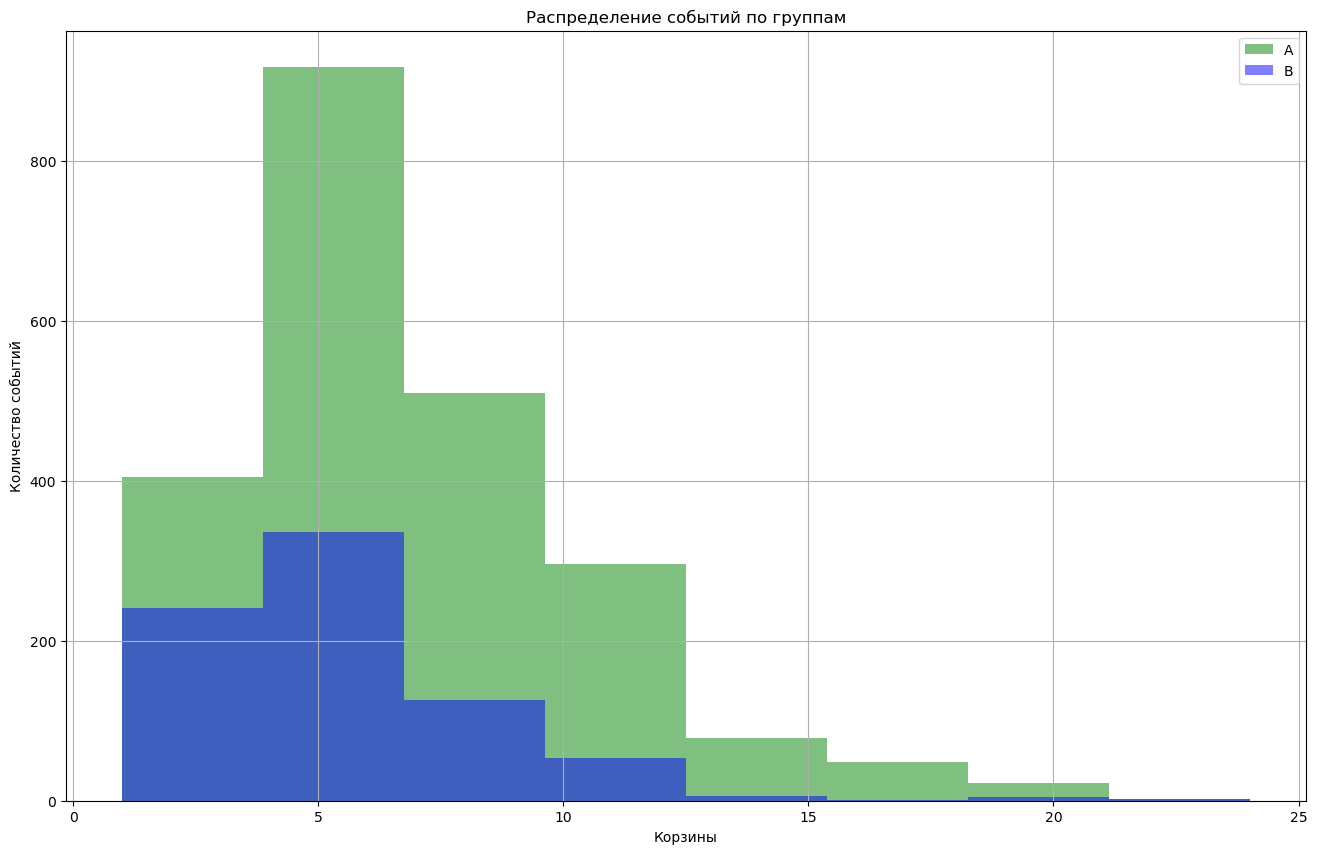

In [34]:
plt.figure(figsize=(16, 10))
all_tables.groupby(['user_id','group']).agg({'event_name':'count'}).reset_index()\
.query('event_name != 0 and group == "A"')['event_name'].hist(bins=8, alpha=0.5, color='green')
all_tables.groupby(['user_id','group']).agg({'event_name':'count'}).reset_index()\
.query('event_name != 0 and group == "B"')['event_name'].hist(bins=8, alpha=0.5, color='blue')
plt.legend(['A', 'B'])
plt.title('Распределение событий по группам')
plt.xlabel('Корзины')
plt.ylabel('Количество событий')
plt.show()

* Как видим событий на 1 пользователя больше в группе А, посмотрим на цифры;
* Оба распределения похожи и по графику видно что они близки к нормальному;

In [35]:
all_tables.groupby(['user_id','group']).agg({'event_name':'count'}).reset_index()\
.groupby('group').mean().round()

,event_name
group,
A,7.0
B,5.0


In [36]:
ttest_group = all_tables.groupby(['user_id','group']).agg({'event_name':'count'}).reset_index()

* Среднее количество событий на пользователя, без учета пользователей не совершавших событий,  в группе А ~ 7, в группе B ~ 5;

**Посмотрим как число событий в выборках распределено по дням:**

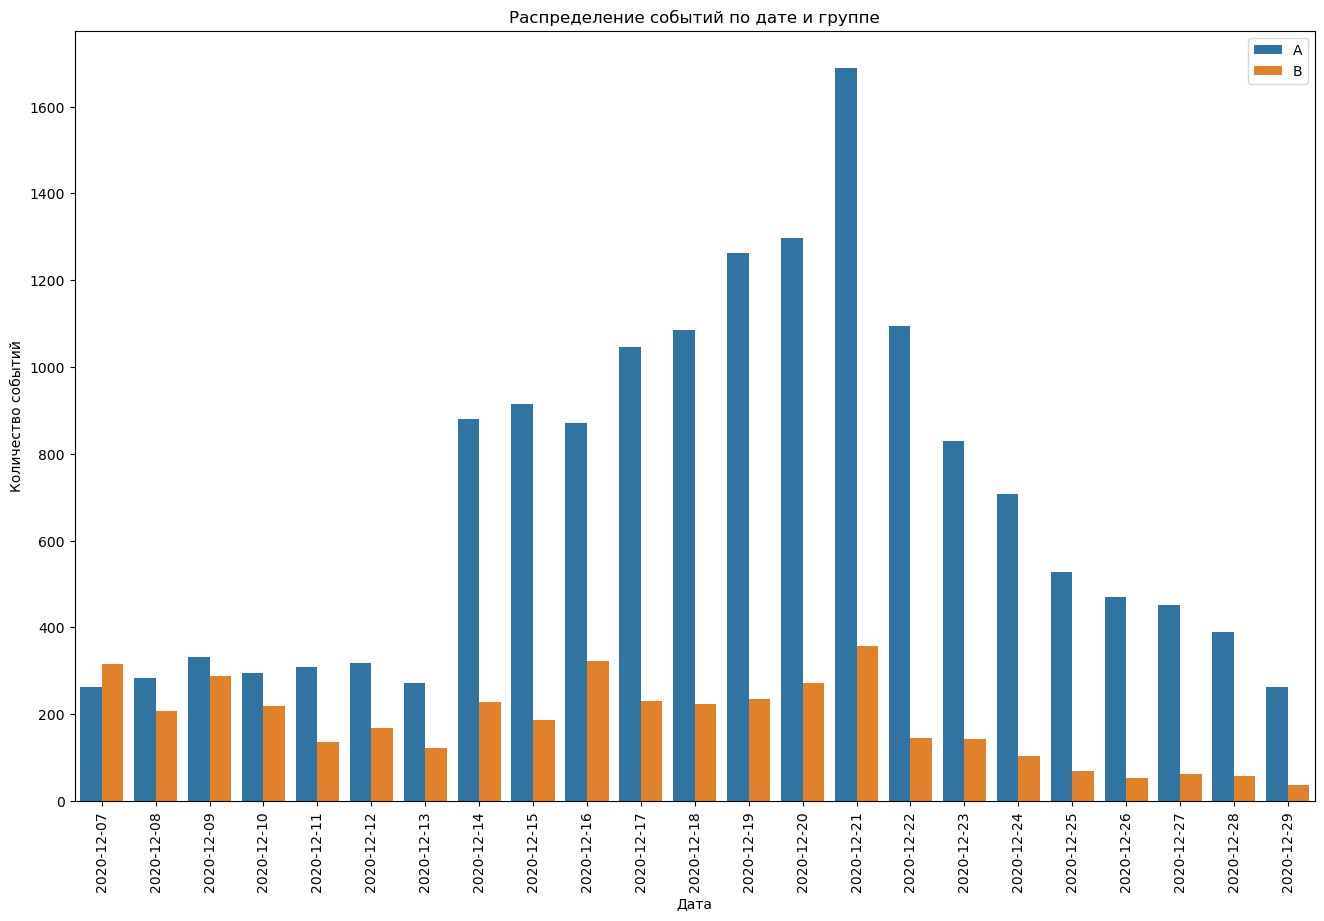

In [37]:
plt.figure(figsize=(16, 10))
# строим столбчатый график средствами seaborn
sns.countplot(x='event_date', data=all_tables.sort_values(by='event_date'), hue='group')
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Распределение событий по дате и группе')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=90)
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='upper right', fontsize=10)
# отображаем график на экране
plt.show()

* Пользователи совершали события практически равномерно с 07.12 по 13.12 включительно, потом пошел резкий рост событий группы `A` вплоть до 21.12, потом пошло снижение;

Посмотрим возможно это связано с тем что пользователи регистрировались непосредственно в данные даты:

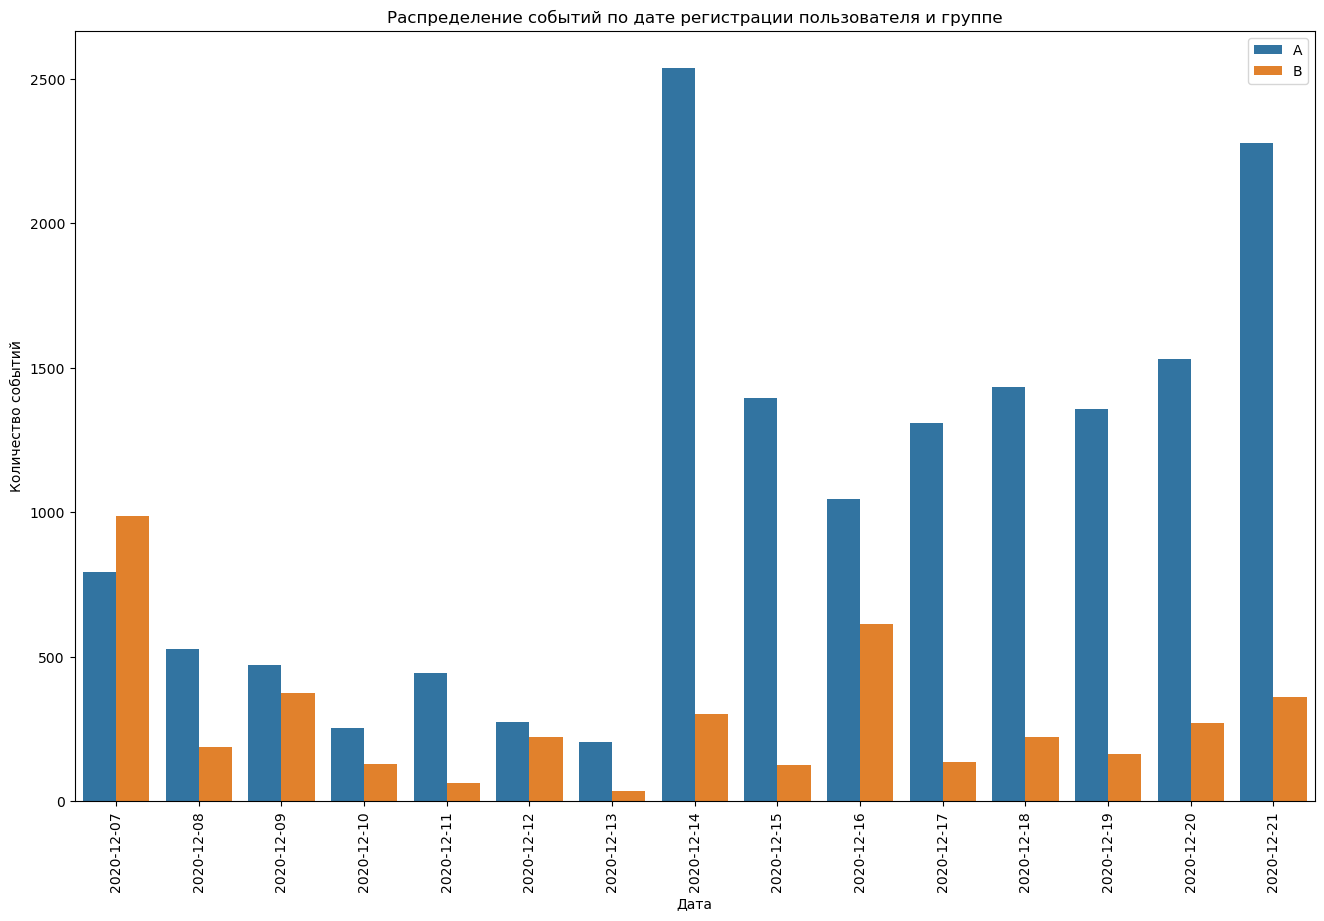

In [38]:
plt.figure(figsize=(16, 10))
# строим столбчатый график средствами seaborn
sns.countplot(x='first_date', data=all_tables.sort_values(by='first_date'), hue='group')
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Распределение событий по дате регистрации пользователя и группе')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=90)
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='upper right', fontsize=10)
# отображаем график на экране
plt.show()

* Пользователи группы `А` зарегистрированные 14.12 оказались очень активными, они и задали планку по количеству событий на предыдущем графике;

**Посмотрим Как меняется конверсия в воронке в выборках на разных этапах**

Посмотрим как выглядит продуктовая воронка по событиям. Если читать логику наименований события то получается такая картина:

* Сначала клиент совершает login(вход) 
* Потом product_page(заходит на страницу продукта) 
* Далее product_cart	(заходит в корзину с товарами) 
* И в конечном итоге purchase(совершает покупку). 

Проверим эту гипотезу:

In [39]:
funnel_tables = all_tables.groupby('event_name').agg({'event_dt':'count'}).sort_values(by='event_dt',ascending=False)
funnel_tables

,event_dt
event_name,
login,9054
product_page,5588
purchase,2736
product_cart,2656


In [40]:
funnel_tables = all_tables.groupby(['event_name','group']).agg({'user_id':'nunique'}).reset_index()
funnel_tables_A = funnel_tables[funnel_tables['group']=='A'].sort_values(by='user_id',ascending=False)
funnel_tables_B = funnel_tables[funnel_tables['group']=='B'].sort_values(by='user_id',ascending=False)
funnel_tables_A = funnel_tables_A.append(funnel_tables_A[funnel_tables_A.index==6]).reset_index().drop(index=2)\
[['event_name','user_id','group']]
funnel_tables_B = funnel_tables_B.append(funnel_tables_B[funnel_tables_B.index==7]).reset_index().drop(index=2)\
[['event_name','user_id','group']]

C:\Users\Леонид\AppData\Local\Temp\ipykernel_6664\1972795851.py:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Леонид\AppData\Local\Temp\ipykernel_6664\1972795851.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



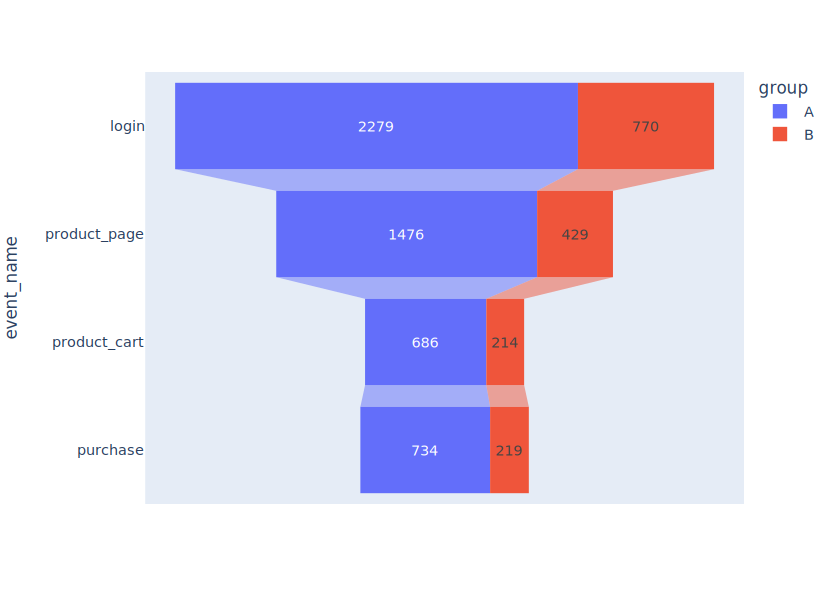

In [41]:
fig = px.funnel(funnel_tables_A.merge(funnel_tables_B, how='outer'), x='user_id', y='event_name', color='group')
fig.show()

In [42]:
all_tables['user_id'].nunique()

3050

Видим что предположение почти подтвердилось кроме последних 2х событий, рассмотрим события на примере случайных пользователей из выборки отсортируем по времени события:

In [43]:
all_tables[all_tables['details'] != 0]

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date,lifetime
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,0 days
17,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-14 18:51:34,purchase,4.99,2020-12-14,0 days
18,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-15 02:39:20,purchase,4.99,2020-12-15,1 days
19,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-18 04:33:43,purchase,9.99,2020-12-18,4 days
20,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-20 04:12:27,purchase,4.99,2020-12-20,6 days
...,...,...,...,...,...,...,...,...,...,...,...
23030,183D7512DBC06186,A,recommender_system_test,2020-12-20,EU,PC,2020-12-23 23:26:31,purchase,4.99,2020-12-23,3 days
23051,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android,2020-12-21 07:05:07,purchase,4.99,2020-12-21,0 days
23052,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android,2020-12-22 17:04:22,purchase,4.99,2020-12-22,1 days
23053,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android,2020-12-23 10:04:37,purchase,4.99,2020-12-23,2 days


In [44]:
all_tables[all_tables['user_id']=='A7A3664BD6242119'].sort_values(by='event_dt')

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date,lifetime
11,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:02,login,0.0,2020-12-20,0 days
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,0.0,2020-12-20,0 days
12,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-21 00:40:58,login,0.0,2020-12-21,1 days
9,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-21 00:40:59,product_page,0.0,2020-12-21,1 days
10,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-25 05:19:45,product_page,0.0,2020-12-25,5 days
13,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-25 05:19:45,login,0.0,2020-12-25,5 days


In [45]:
all_tables[all_tables['user_id']=='D1ABA3E2887B6A73'].sort_values(by='event_dt')

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date,lifetime
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,0 days
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,0.00,2020-12-07,0 days
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,0.00,2020-12-07,0 days
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,0 days


In [46]:
all_tables[all_tables['user_id']=='7C5C12FA1B5AB710'].sort_values(by='event_dt')

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date,lifetime
23051,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android,2020-12-21 07:05:07,purchase,4.99,2020-12-21,0 days
23059,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android,2020-12-21 07:05:07,login,0.00,2020-12-21,0 days
23055,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android,2020-12-21 07:05:08,product_page,0.00,2020-12-21,0 days
23052,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android,2020-12-22 17:04:22,purchase,4.99,2020-12-22,1 days
23056,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android,2020-12-22 17:04:22,product_page,0.00,2020-12-22,1 days
23060,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android,2020-12-22 17:04:22,login,0.00,2020-12-22,1 days
23053,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android,2020-12-23 10:04:37,purchase,4.99,2020-12-23,2 days
23061,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android,2020-12-23 10:04:37,login,0.00,2020-12-23,2 days
23057,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android,2020-12-23 10:04:40,product_page,0.00,2020-12-23,2 days
23054,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android,2020-12-26 10:43:10,purchase,4.99,2020-12-26,5 days


* По полученым данным видим что клиент обязательно проходит вход(login), а затем он может и посмотреть карточку товара(product_page) и совершить покупку(purchase), а после совершения покупки(через несколько секунд) попадает в корзину (product_cart) и то не всегда, возможно (т.к. события происходят одномоментно) клиент перенаправляется с другого сайта или приложения. Следовательно отследить точную продуктовую воронку на основе большого кольчиства данных не предстваляется возможным. **БУДЕМ СЧИТАТЬ КОНВЕРСИЮ ОТ ЧИСЛА ВХОДОВ(`login`)**

**Вывод:**
* Событий на 1 пользователя больше в группе А. Среднее количество событий на пользователя, без учета пользователей не совершавших событий, в группе А ~ 7, в группе B ~ 5;
* Оба распределения похожи и по графику видно что они близки к нормальному;
* По полученым данным видим что клиент обязательно проходит вход(login), а затем он может и посмотреть карточку товара(product_page) и совершить покупку(purchase), а после совершения покупки(через несколько секунд) попадает в корзину (product_cart) и то не всегда, возможно (т.к. события происходят одномоментно) клиент перенаправляется с другого сайта или приложения. Следовательно отследить точную продуктовую воронку на основе большого кольчиства данных не предстваляется возможным. БУДЕМ СЧИТАТЬ КОНВЕРСИЮ ОТ ЧИСЛА ВХОДОВ(login);

## Оценим результаты A/B-тестирования

In [47]:
all_tables_pivot = all_tables.pivot_table(index = 'event_name',columns = 'group',values = 'user_id', aggfunc = 'nunique')\
.sort_values(by = 'A',ascending=False).reset_index()

In [48]:
all_tables_pivot['conversion_A'] = all_tables_pivot['A']/all_tables_pivot['A'][0]*100
all_tables_pivot['conversion_B'] = all_tables_pivot['B']/all_tables_pivot['B'][0]*100
all_tables_pivot['delta'] = (all_tables_pivot['conversion_B'] - all_tables_pivot['conversion_A']).round()
all_tables_pivot

group,event_name,A,B,conversion_A,conversion_B,delta
0,login,2279,770,100.000000,100.000000,0.0
1,product_page,1476,429,64.765248,55.714286,-9.0
2,purchase,734,219,32.207108,28.441558,-4.0
3,product_cart,686,214,30.100921,27.792208,-2.0


* Результат A/B теста: Конверсия группы В относительно группы А, вместо роста показала только снижение по всем показателям, а именно: product_page -9%, purchase -4%, product_cart -2%.

Проверим статистическую разницу долей z-критерием.

**Сделаем функцию для проверки гипотезы о равенстве долей для двух групп:**

* event_1 - количество пользователей совершивших действие в 1 группе

* event_2 - количество пользователей совершивших действие в 2 группе

* total_1 - количество пользователей всего в 1 группе

* total_2 - количество пользователей всего во 2 группе

* alpha - критический уровень статистической значимости

In [49]:
def z_test_value(event_1, event_2, total_1, total_2, alpha):
    # доля успешных действий в 1 группе
    share_1 = event_1/total_1
    # доля успешных действий во 2 группе
    share_2 = event_2/total_2
    
    print(event_1, event_2, total_1,total_2)
    
    # комбинированная доля
    share_combined = (event_1 + event_2)/(total_1 + total_2)
    # разница в долях между группами
    diff = share_1 - share_2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = diff/(share_combined *(1-share_combined)*(1/total_1 + 1/total_2))**0.5
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    dist = stats.norm(0,1)
    # считаем p-value
    p_value = (1 - dist.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

Сформулируем гипотезы и проведем `z-test` по каждому событию групп `A` и `B`:

Гипотезы:

**Нулевая: Статистических различий в долях между группами `A` и `B`, по событию `product_page`, нет.** 

**Альтернативная: Статистические различия в долях между группами `A` и `B`, по событию `product_page`, есть.**

**alpha = 0.05**

Обрати, пожалуйста, внимание, что воронка должна заканчиваться целевым действием (оплата), но на графике - последнее событие продуктовая карта, т.е. основная цель пользователя - просмотр продуктовой корзины, что является не совсем корректно. Тут стоит поменять местами

In [50]:
event_1 = all_tables_pivot.loc[1, 'A']
event_2 = all_tables_pivot.loc[1, 'B']
total_1 = all_tables_pivot.loc[0, 'A']
total_2 = all_tables_pivot.loc[0, 'B']
alpha = 0.05

In [51]:
z_test_value(event_1, event_2, total_1, total_2, alpha)

1476 429 2279 770
p-значение:  7.302688278310043e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


Гипотезы:

**Нулевая: Статистических различий в долях между группами `A` и `B`, по событию `purchase`, нет.** 

**Альтернативная: Статистические различия в долях между группами `A` и `B`, по событию `purchase`, есть.**

**alpha = 0.05**

In [52]:
event_1 = all_tables_pivot.loc[2, 'A']
event_2 = all_tables_pivot.loc[2, 'B']

In [53]:
z_test_value(event_1, event_2, total_1, total_2, alpha)

734 219 2279 770
p-значение:  0.05131111814183842
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотезы:

**Нулевая: Статистических различий в долях между группами `A` и `B`, по событию `product_cart`, нет.** 

**Альтернативная: Статистические различия в долях между группами `A` и `B`, по событию `product_cart`, есть.**

**alpha = 0.05**

In [54]:
event_1 = all_tables_pivot.loc[3, 'A']
event_2 = all_tables_pivot.loc[3, 'B']

In [55]:
z_test_value(event_1, event_2, total_1, total_2, alpha)

686 214 2279 770
p-значение:  0.22463227493216675
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:**
* Результат A/B теста: Конверсия группы В относительно группы А, вместо роста показала только снижение по всем показателям, а именно: product_page -9%, purchase -4%, product_cart -2%.
* По событию `product_page` есть статистическая разница между группами `A` и `B`. По событиям `product_cart` и `purchase` стастистических различий в долях - нет.

## Общий вывод

Мы провели оценку результатов A/B теста, к таким выводам мы пришли:
* Явные дубликаты в таблице `final_ab_events` - отсутствуют. Обнаружили пропуски в столбце `details`. Заполнен только для покупок, `purchase`, хранится стоимость покупки в долларах; `product_cart` - по всей видимости отображает когда пользователь зашел на страницу "корзина с товарами"; `product_page` - отображает когда пользователь зашел на "страницу продукта"; `login` - событие когда пользователь "авторизовался". Заполнили эти пропуски числом `0`, для удобной работы с таблицей в дальнейшем.
* Тип данных столбца `event_dt` таблицы `final_ab_events` - `object`, привели к типу `datetime` и добавили еще 1 столбец `event_date` - где отобразили только дату события;
* В таблице `ab_project_marketing_events` пропуски и явные дубликаты отсутствуют;
* Тип данных столбцов `start_dt` и `finish_dt` таблицы `ab_project_marketing_events` - `object`, привели к типу `datetime`;
* В таблице `final_ab_new_users` пропуски и явные дубликаты отсутствуют;
* Тип данных столбца `first_date` таблицы `final_ab_new_users` - `object`, привели к типу `datetime`;
* в таблице `ab_project_marketing_events` пропуски и явные дубликаты отсутствуют, типы данных так же в порядке - оставляем без изменений;
* В таблицу участников теста `final_ab_participants` зачесались данные другого теста, а именно `interface_eu_test` - конкурирующий тест.Есть пересечения в группах нашего теста и конкурирующего. Всего 1602 пользователя учавствуют сразу в двух тестах.Нам интересны только те пользователи которые попали в группу A(контрольную) теста `interface_eu_test`, иначе будет непонятно, что именно повлияло на действия пользователя новая система рекомендаций или новый интерфейс.
* В нашей таблице нет участников теста котороый попали сразу в 2 группы(контрольную и экспериментальную) - это очень радует;
* В данных информация о пользователях зарегистрировавшихся с 07.12.2020 по 21.12.2020;
* Во время набора пользователей маркетинговые акции не проходили, но проходили во время проведения теста, следовательно пользователи из регионов `EU, N.America` совершавшие события после `2020-12-25`включительно и региона `CIS` совершавшие события после `2020-12-30` включительно могли учавствовать в этих маркетинговых мероприятиях. На поведение данных пользователей могла повлиять и маркетинговая акция, но на группы А и В она повляет одинаково. Следовательно на относительную конверсию группы В к группе А - не будет иметь воздействие;
* Последнее действие пользователей в данных было 29.12.2020 - по всей видимости в январские праздники сервис не работал;
* В наших данных есть пользователи и из других регионов, они могут повлиять на результаты теста, оставили только пользователей из региона EU;
* В тест попало только 7% новых пользователей из региона `EU` вместо ожидаемых 15%;
* В конечном итоге количество участников теста составляет 5568 пользователей, что меньше на 432 чем ожидалось;
* Необходимо оценить улучшение метрик пользователей в первые 14 дней с момента регитрации, удалили события совершенные посльзователями после этого периода;
* Событий на 1 пользователя больше в группе А. Среднее количество событий на пользователя, без учета пользователей не совершавших событий, в группе А ~ 7, в группе B ~ 5;
* Оба распределения похожи и по графику видно что они близки к нормальному;
* По полученым данным видим что клиент обязательно проходит вход(login), а затем он может и посмотреть карточку товара(product_page) и совершить покупку(purchase), а после совершения покупки(через несколько секунд) попадает в корзину (product_cart) и то не всегда, возможно (т.к. события происходят одномоментно) клиент перенаправляется с другого сайта или приложения. Следовательно отследить точную продуктовую воронку на основе большого кольчиства данных не предстваляется возможным. БУДЕМ СЧИТАТЬ КОНВЕРСИЮ ОТ ЧИСЛА ВХОДОВ(login);
* **Результат A/B теста: Конверсия группы В относительно группы А, вместо роста показала только снижение по всем показателям, а именно: product_page -9%, purchase -4%, product_cart -2%.**
* **По событию `product_page` есть статистическая разница между группами `A` и `B`. По событиям `product_cart` и `purchase` стастистических различий в долях - нет.**

**Общие рекомендации оп результатам A/B теста:**

Новая система рекомендаций по предоставленным данным имеет отрицательное влияние на конверсию пользователей.

Но учитывая то, что некоторые пункты ТЗ не соблюдены. 

И имеются статистические различия в долях между группами `A` и `B`, по обытию `product_page`. 

**РЕКОМЕНДУЮ ПЕРЕЗАПУСТИТЬ ТЕСТ И ЗАНОВО ПРОАНАЛИЗИРОВАТЬ**